## Importing Required Libraries

In [1]:
#import general packages
import os
import argparse
import logging
import sys
from typing import Dict, List
from dpu_utils.utils.richpath import RichPath
import pickle

import torch
from tqdm import tqdm
import pandas as pd

# Setting up local details:
# This should be the location of the checkout of the THEMAP repository:
repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")
EXT_CHEM_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "ext_chem")
EXT_PROT_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "ext_prot")
PROTONET_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "FSMol_Eval_ProtoNet")
INTRA_HARDNESS_TRAIN_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "int_chem", "train")
INTRA_HARDNESS_TEST_PATH = os.path.join(DATASET_PATH, "fsmol_hardness", "int_chem", "test")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [2]:
# import visualization packages
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from themap.utils import internal_hardness, otdd_hardness, normalize, protein_hardness_from_distance_matrix

light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

#matplotlib.use("pgf")

matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 20,
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

In [3]:
ESM2_t6_8M = os.path.join(EXT_PROT_PATH, 'esm2_t6_8M_UR50D.pkl')
ESM2_t12_35M = os.path.join(EXT_PROT_PATH, 'esm2_t12_35M_UR50D.pkl')
ESM2_t30_150M = os.path.join(EXT_PROT_PATH, 'esm2_t30_150M_UR50D.pkl')
ESM2_t33_650M = os.path.join(EXT_PROT_PATH, 'esm2_t33_650M_UR50D.pkl')
ESM2_t36_3B = os.path.join(EXT_PROT_PATH, 'esm2_t36_3B_UR50D.pkl')
mapping_model_to_path = {"ESM2_t6_8M": ESM2_t6_8M, "ESM2_t12_35M": ESM2_t12_35M, "ESM2_t30_150M": ESM2_t30_150M, "ESM2_t33_650M": ESM2_t33_650M, "ESM2_t36_3B": ESM2_t36_3B}


protonet_16= os.path.join(PROTONET_PATH, 'summary', 'ProtoNet_summary_num_train_requested_16.csv')
protonet_32= os.path.join(PROTONET_PATH, 'summary', 'ProtoNet_summary_num_train_requested_32.csv')
protonet_64= os.path.join(PROTONET_PATH, 'summary', 'ProtoNet_summary_num_train_requested_64.csv')
protonet_128= os.path.join(PROTONET_PATH, 'summary', 'ProtoNet_summary_num_train_requested_128.csv')

## Creating hardness dataframe vs pderformance measure

In [4]:
available_otdd = ['test/hardness/otdd_Roberta-Zinc480M-102M.pkl',
                  'test/hardness/otdd_desc2D.pkl',
                  'test/hardness/otdd_gin_supervised_infomax.pkl',
                  'test/hardness/otdd_unimol.pkl',
                  'test/hardness/otdd_gin_supervised_contextpred.pkl',
                  'test/hardness/otdd_gin_supervised_masking.pkl',
]

dict_keys(['train_chembl_ids', 'test_chembl_ids', 'distance_matrices'])
Numebr of NaN values in the hardness matrix:  1


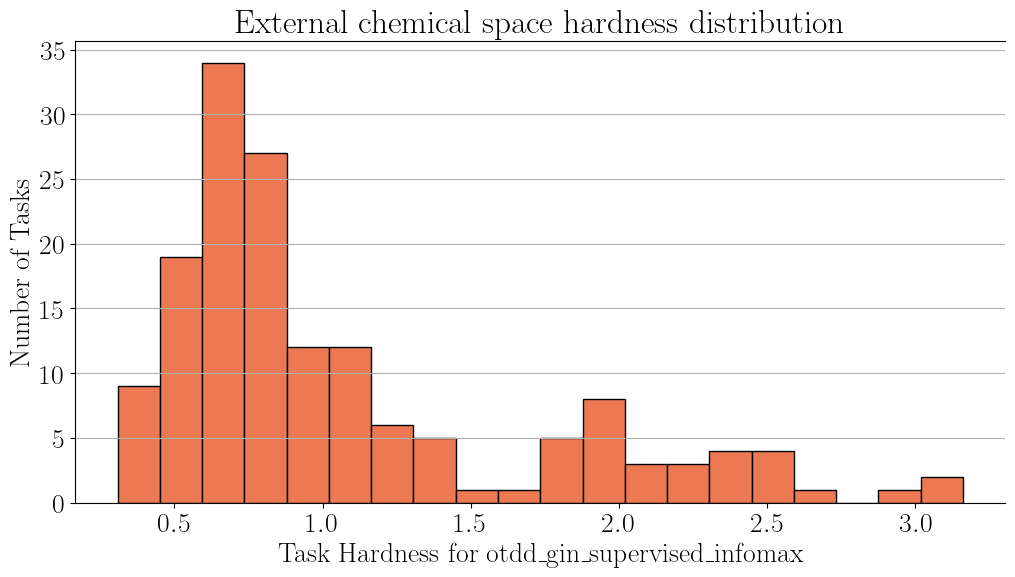

In [5]:
otdd_model = "otdd_gin_supervised_infomax.pkl"
weighting_model = "rf_16.pkl"
PATH_TO_OTDD = os.path.join(EXT_CHEM_PATH, otdd_model)
PATH_TO_INTRA_HARDNESS_TRAIN = os.path.join(INTRA_HARDNESS_TRAIN_PATH, weighting_model)

otdd_hardness_df = otdd_hardness(PATH_TO_OTDD, PATH_TO_INTRA_HARDNESS_TRAIN, k=10, train_tasks_weighted=True, weighting_method='rf')
otdd_hardness_df['hardness_norm'] = normalize(otdd_hardness_df['hardness']) 
# Visualizing the Hardness Distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(otdd_hardness_df['hardness'], bins=20, color=light_color, edgecolor=dark_color)
ax.set_title("External chemical space hardness distribution")
ax.set_xlabel(f"Task Hardness for {otdd_model.split('.')[0]}")
ax.set_ylabel("Number of Tasks")
ax.grid(axis='y')
ax.spines['right'].set_visible(False)

#ax.grid(True)
plt.show()
fig.savefig('assets/EXT_CHEM_hist.pdf', transparent=True, backend='pgf', bbox_inches='tight')
fig.savefig('assets/EXT_CHEM_hist.svg', transparent=True, bbox_inches='tight')

In [17]:
internal_hardness_model = "rf_16.pkl"
PATH_TO_INTRA_HARDNESS_TEST = os.path.join(INTRA_HARDNESS_TEST_PATH, weighting_model)
otdd_hardness_df = internal_hardness(otdd_hardness_df, internal_hardness_path=PATH_TO_INTRA_HARDNESS_TEST)
otdd_hardness_df['internal_hardness_norm'] = normalize(otdd_hardness_df['internal_hardness'])

output_results = pd.read_csv(protonet_128)
x = pd.merge(output_results[['assay', 'delta_auprc', 'roc_auc']], otdd_hardness_df, on="assay")
print("Peasrson EXT_CHEM vs Performance measure:", x['hardness_norm'].corr( x['roc_auc']))
print("Peasrson INT_CHEM vs Performance measure:", x['internal_hardness_norm'].corr( x['roc_auc']))

ESM2_model = "ESM2_t33_650M"
protein_path = mapping_model_to_path[ESM2_model]
protein_hardness_df = protein_hardness_from_distance_matrix(protein_path, k=10)

final_df = pd.merge(protein_hardness_df, x, on="assay")
final_df['inter_protein_hardness_norm'] = final_df['protein_hardness_mean_norm'] + final_df['hardness_norm']
final_df['inter_intra_protein_hardness_norm'] = final_df['inter_protein_hardness_norm'] + final_df['internal_hardness_norm']
print("Pearson EXT_CHEM + EXT_PROT vs Performance measure:", (final_df['hardness_norm'] + final_df['protein_hardness_mean_norm']).corr( final_df['roc_auc']))
print("Pearson EXT_CHEM and EXT_PROT:", final_df['hardness_norm'].corr( final_df['protein_hardness_mean_norm']))
print("Pearson EXT_CHEM and INT_CHEM:", final_df['hardness_norm'].corr( final_df['internal_hardness_norm']))

Peasrson EXT_CHEM vs Performance measure: -0.6272649099569214
Peasrson INT_CHEM vs Performance measure: -0.4109128375064308
Pearson EXT_CHEM + EXT_PROT vs Performance measure: -0.59669707108683
Pearson EXT_CHEM and EXT_PROT: 0.36399631935419546
Pearson EXT_CHEM and INT_CHEM: 0.018223501270114108


## Correlation between hardenss and performance measure

-0.6272649099569214
-0.34482435861350225
-0.59669707108683
-0.7188987917431472


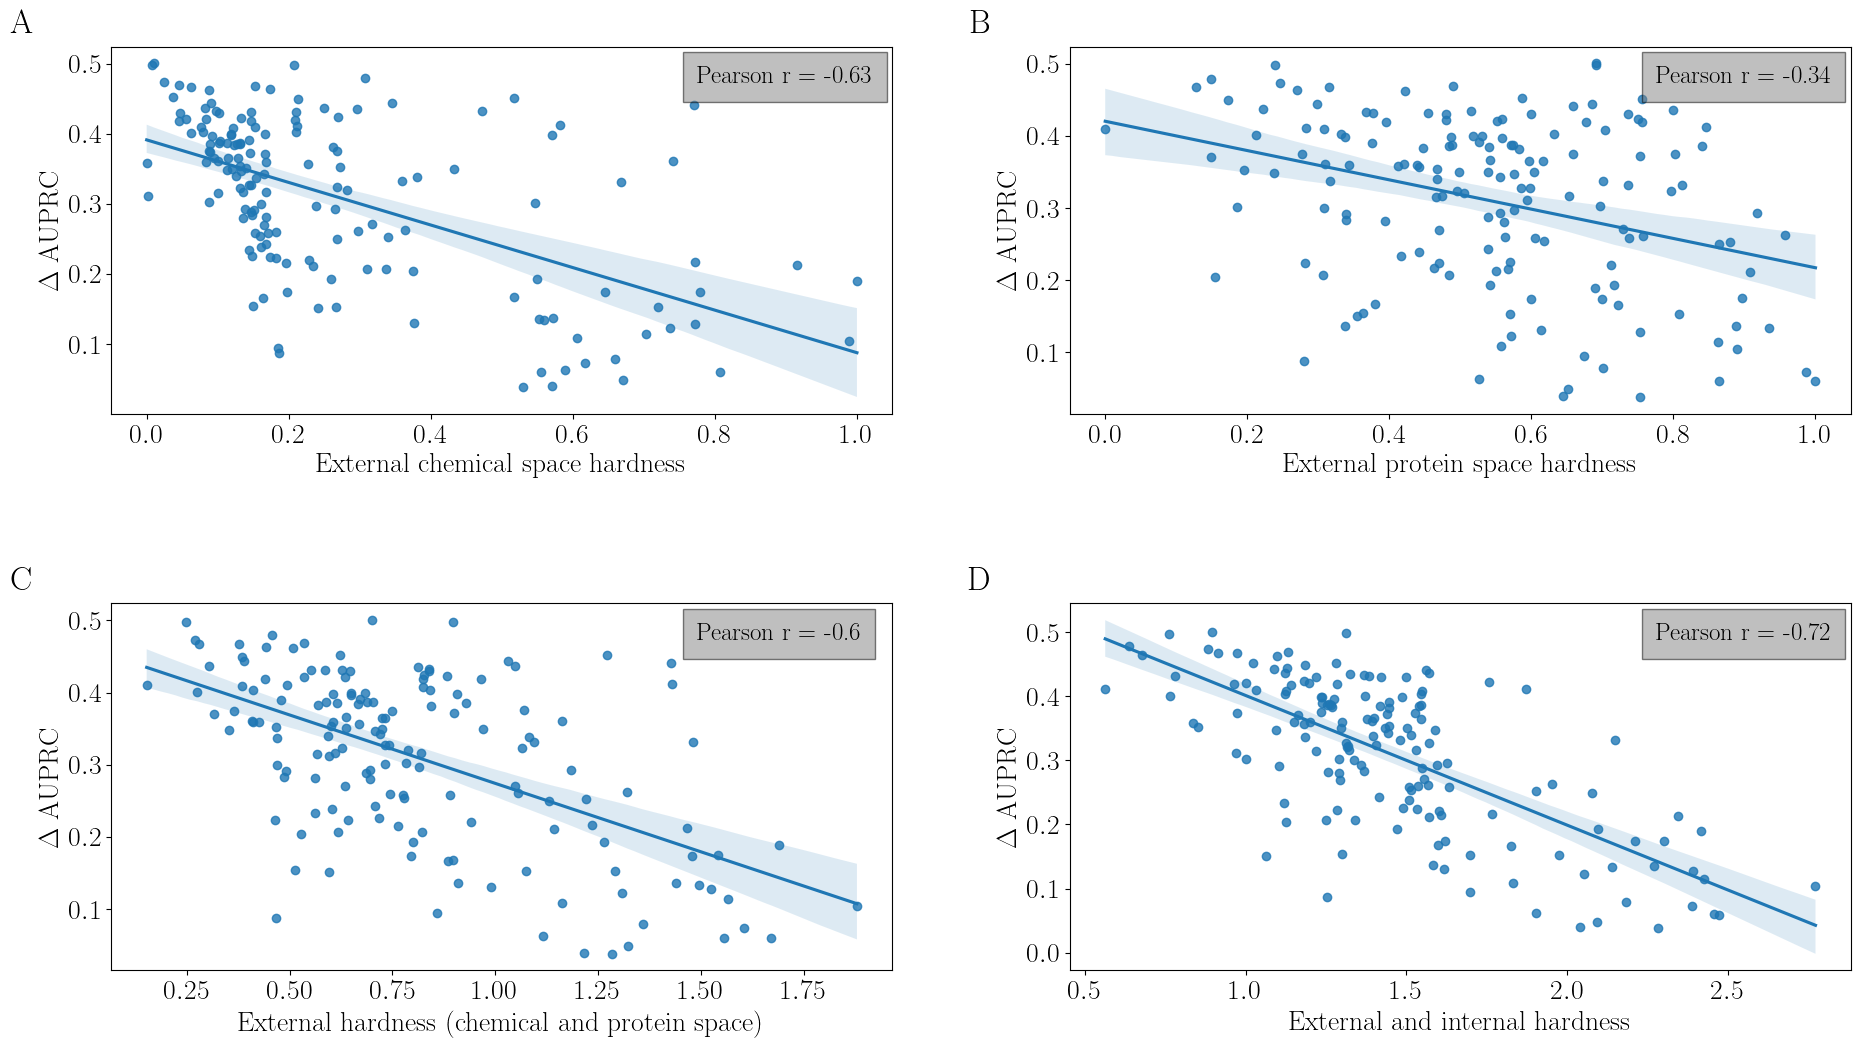

In [20]:
print(final_df['hardness_norm'].corr( final_df['roc_auc']))
print(final_df['protein_hardness_mean_norm'].corr( final_df['roc_auc']))
print(final_df['inter_protein_hardness_norm'].corr( final_df['roc_auc']))
print(final_df['inter_intra_protein_hardness_norm'].corr( final_df['roc_auc']))

corr1 = round(final_df['hardness_norm'].corr( final_df['roc_auc']), 2)
corr2 = round(final_df['protein_hardness_mean_norm'].corr( final_df['roc_auc']), 2)
corr3 = round(final_df['inter_protein_hardness_norm'].corr( final_df['roc_auc']), 2)
corr4 = round(final_df['inter_intra_protein_hardness_norm'].corr( final_df['roc_auc']), 2)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 12))
sns.regplot(x="hardness_norm", y="delta_auprc",data=final_df, ax=ax0)
sns.regplot(x="protein_hardness_mean_norm", y="delta_auprc", data=final_df, ax=ax1)
sns.regplot(x="inter_protein_hardness_norm", y="delta_auprc", data=final_df, ax=ax2)
sns.regplot(x="inter_intra_protein_hardness_norm", y="delta_auprc",data=final_df, ax=ax3)


ax0.set(xlabel='External chemical space hardness')
ax1.set(xlabel='External protein space hardness')
ax2.set(xlabel='External hardness (chemical and protein space)')
ax3.set(xlabel='External and internal hardness')

ax0.set(ylabel='$\Delta$ AUPRC')
ax1.set(ylabel='$\Delta$ AUPRC')
ax2.set(ylabel='$\Delta$ AUPRC')
ax3.set(ylabel='$\Delta$ AUPRC')


ax0.text(0.75, 0.9, 'Pearson r = {}'.format(corr1), bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=18, transform=ax0.transAxes)
ax0.text(-0.1, 1.1, 'A', transform=ax0.transAxes,
      fontsize=24, fontweight='bold', va='top', ha='right')


ax1.text(0.75, 0.9, 'Pearson r = {}'.format(corr2), bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=18, transform=ax1.transAxes)
ax1.text(-0.1, 1.1, 'B', transform=ax1.transAxes,
      fontsize=24, fontweight='bold', va='top', ha='right')


ax2.text(0.75, 0.9, 'Pearson r = {}'.format(corr3), bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=18, transform=ax2.transAxes)
ax2.text(-0.1, 1.1, 'C', transform=ax2.transAxes,
      fontsize=24, fontweight='bold', va='top', ha='right')


ax3.text(0.75, 0.9, 'Pearson r = {}'.format(corr4), bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=18, transform=ax3.transAxes)
ax3.text(-0.1, 1.1, 'D', transform=ax3.transAxes,
      fontsize=24, fontweight='bold', va='top', ha='right')


fig.tight_layout(pad=3.0)
fig.savefig('assets/Hardness_vs_ProtoNet.pdf', transparent=True, backend='pgf', bbox_inches='tight')
fig.savefig('assets/Hardness_vs_ProtoNet.svg')
plt.show()

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))
ax0.hist(final_df['hardness_norm'], bins=20, color=light_color, edgecolor=dark_color)
ax1.hist(final_df['protein_hardness_mean_norm'], bins=20, color=light_color, edgecolor=dark_color)

ax0.set_title("Task Hardness Distribution")
ax0.set_xlabel("External chemical space hardness")
ax0.set_ylabel("Number of tasks")
ax0.set_ylim([0, 35])
ax0.text(-0.1, 1.1, 'A', transform=ax0.transAxes,
      fontsize=24, fontweight='bold', va='top', ha='right')

ax1.set_title("Task Hardness Distribution")
ax1.set_xlabel("External protein space hardness")
ax1.set_ylim([0, 35])
ax1.text(-0.1, 1.1, 'B', transform=ax1.transAxes,
      fontsize=24, fontweight='bold', va='top', ha='right')



fig.savefig('assets/EXT_CHEM_EXT_PROT_hist.pdf', transparent=True, backend='pgf', bbox_inches='tight')
plt.show()

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 6))
final_df.plot.scatter(x='hardness_norm', y='protein_hardness_mean_norm', c='delta_auprc', colormap='viridis', ax=ax0, s=50, alpha=0.8)

ax0.set_xlabel('External chemical hardness (normalized)')
ax0.set_ylabel('External protein hardness (normalized)')
ax0.grid(True)
ax0.axline((0, 0), slope=1, color='black', linestyle='--', linewidth=1)

corr5 = round(final_df['hardness_norm'].corr(final_df['protein_hardness_mean_norm']), 2)
ax0.text(0.65, 0.93, 'Pearson r = {}'.format(corr5), bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, transform=ax0.transAxes, fontsize=14)
ax0.text(-0.1, 1.1, 'A', transform=ax0.transAxes,
      fontsize=24, fontweight='bold', va='top', ha='right')

#fig.savefig('assets/hardness_corr.svg', format='svg')

final_df.plot.scatter(x='hardness_norm', y='internal_hardness_norm', c='delta_auprc', colormap='viridis', ax=ax1, s=50, alpha=0.8)

ax1.set_xlabel('External chemical hardness (normalized)')
ax1.set_ylabel('Internal hardness (normalized)')
ax1.grid(True)
ax1.axline((0, 0), slope=1, color='black', linestyle='--', linewidth=1)

corr5 = round(final_df['hardness_norm'].corr(final_df['internal_hardness_norm']), 2)
ax1.text(0.65, 0.93, 'Pearson r = {}'.format(corr5), bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, transform=ax1.transAxes, fontsize=14)

#fig.savefig('assets/hardness_corr.svg', format='svg')
ax1.text(-0.1, 1.1, 'B', transform=ax1.transAxes,
      fontsize=24, fontweight='bold', va='top', ha='right')

fig.savefig('assets/hardness_comparisson.pdf', transparent=True, backend='pgf', bbox_inches='tight')
plt.show()